In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import convmorph as cm
from torch.utils.data import Dataset, DataLoader

## Load Data

In [18]:
with open("../data/convmorph_dataset_random.pkl", "rb") as fin:
    (cm2_vocabs, cm2_embs) = pickle.load(fin)
with open("../data/0505-1222-oreo-random/const_vocab.pkl", "rb") as fin:
    const_vocab = pickle.load(fin)

In [19]:
len(cm2_vocabs)

129538

In [20]:
cm2_ds = cm.ConvmorphDataset(cm2_vocabs, cm2_embs)
cm2oe_ds = cm.ConvmorphOpEmbDataset(cm2_vocabs, cm2_embs, const_vocab)
print(f"cm2_dataset: {len(cm2_ds):6d}")
print(f"cm2oe_dataset: {len(cm2oe_ds):6d}")

building dataset:   0%|          | 0/129538 [00:00<?, ?it/s]

building dataset:   0%|          | 0/129538 [00:00<?, ?it/s]

  0%|          | 0/120838 [00:00<?, ?it/s]

cm2_dataset: 120838
cm2oe_dataset: 120838


### Load train-testing splits

In [22]:
import pickle
cm2_split_path = "../data/split_indices_120k.pkl"
(cm2_train_ds, cm2_test_ds, 
 cm2_train_eval_ds,
 cm2_train_idxs, cm2_test_idxs) = cm.split_train_test(cm2_split_path, cm2_ds)
(cm2oe_train_ds, cm2oe_test_ds, 
 cm2oe_train_eval_ds,
 cm2oe_train_idxs, cm2oe_test_idxs) = cm.split_train_test_oreo(cm2_split_path, cm2oe_ds)

print("cm2: ", len(cm2_train_ds), len(cm2_test_ds), len(cm2_train_eval_ds))
print("cm2_oe: ", len(cm2oe_train_ds), len(cm2oe_test_ds), len(cm2oe_train_eval_ds))

cm2:  114796 6042 6042
cm2_oe:  114796 6042 6042


## Load Model

### DL model (conv-based)

In [23]:
from convmorph import ConvmorphArcModel
# DL model for 2-char-word
model_cm2 = ConvmorphArcModel().to("cuda")
states = torch.load("../data/0505-1207-arc-random/model.pth")
model_cm2.load_state_dict(states)
_ = model_cm2.eval()

In [24]:
print("{:.2f}M parameters".format(sum([x.numel() for x in model_cm2.parameters()])/1e6))

11.06M parameters


## DL model (opt-emb)

In [25]:
from convmorph import ConvmorphOreoModel
# DL model for 2-char-word
states = torch.load("../data/0505-1222-oreo-random/model.pth")
n_vocab, h_dim = states["emb.weight"].shape
model_oe2 = ConvmorphOreoModel(n_vocab=n_vocab, h_dim=h_dim).to("cuda")
model_oe2.load_state_dict(states)
_ = model_oe2.eval()

In [27]:
print("{:.2f}M parameters".format(sum([x.numel() for x in model_oe2.parameters()])/1e6))

7.22M parameters


### Linear projection model

$$
AX=B \\
X = (A^\top A)^{-1}A^\top B
$$

In [28]:
linprojX_cm2 = cm.make_linear_projection(cm2_ds, cm2_train_idxs)
linproj_cm2 = cm.LinearProjection(linprojX_cm2, "cuda")

## Metrics

### Two-character words

In [29]:
cm2_eval_embs = torch.tensor(np.vstack([x["target"] for x in cm2_test_ds]), dtype=torch.float32).to("cuda")
cm2_train_eval_embs = torch.tensor(np.vstack([x["target"] for x in cm2_train_eval_ds]), dtype=torch.float32).to("cuda")

In [30]:
cm2_acc_test_dl = cm.compute_accuracy(model_cm2, DataLoader(cm2_test_ds, batch_size=128, shuffle=False), 
                                      cm2_eval_embs, topk=1)
cm2_acc_train_dl = cm.compute_accuracy(model_cm2, DataLoader(cm2_train_eval_ds, batch_size=128, shuffle=False), 
                                       cm2_train_eval_embs, topk=1)
print("CM2 DL conv-based: ")
print("Train/Test Acc: {:.4f}/{:.4f}".format(cm2_acc_train_dl, cm2_acc_test_dl))

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

CM2 DL conv-based: 
Train/Test Acc: 0.0002/0.0002


In [31]:
cm2_acc_test_oe = cm.compute_accuracy(model_oe2, DataLoader(cm2oe_test_ds, batch_size=128, shuffle=False), 
                                      cm2_eval_embs, topk=1)
cm2_acc_train_oe = cm.compute_accuracy(model_oe2, DataLoader(cm2oe_train_eval_ds, batch_size=128, shuffle=False), 
                                       cm2_train_eval_embs, topk=1)
print("CM2 DL OptEmb: ")
print("Train/Test Acc: {:.4f}/{:.4f}".format(cm2_acc_train_oe, cm2_acc_test_oe))

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

CM2 DL OptEmb: 
Train/Test Acc: 0.0895/0.0002


In [32]:
cm2_acc_test_lin = cm.compute_accuracy(linproj_cm2, DataLoader(cm2_test_ds, batch_size=128, shuffle=False), 
                                      cm2_eval_embs, topk=1)
cm2_acc_train_lin = cm.compute_accuracy(linproj_cm2, DataLoader(cm2_train_eval_ds, batch_size=128, shuffle=False), 
                                       cm2_train_eval_embs, topk=1)
print("CM2 Linear: ")
print("Train/Test Acc: {:.4f}/{:.4f}".format(cm2_acc_train_lin, cm2_acc_test_lin))

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

CM2 Linear: 
Train/Test Acc: 0.0028/0.0005


In [33]:
linprojX_cheated = cm.make_linear_projection(cm2_ds, cm2_test_idxs)
linproj_cheated = cm.LinearProjection(linprojX_cheated, "cuda")
linproj_cheated = cm.compute_accuracy(linproj_cheated, DataLoader(cm2_test_ds, batch_size=128, shuffle=False), 
                                      cm2_eval_embs, topk=1)
print("Linproj Cheated Acc: {:.4f}".format(linproj_cheated))

  0%|          | 0/48 [00:00<?, ?it/s]

Linproj Cheated Acc: 0.4419


# cheat version of DL
* conv-based: .0002 (0505-1207-arc-random)
* opt-emb: .5695 (0505-1231-oreo-random)

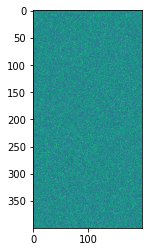

In [34]:
plt.imshow(linprojX_cm2)

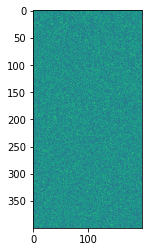

In [35]:
plt.imshow(linprojX_cheated)